---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

## Introduction and Motivation
This page focuses on using unsupervised machine learning to learn more about the song data and identify what sets the top 20 songs apart from the other. The code is divided into two sections: dimensionality reduction and clustering. In dimensionality reduction, I want to simply high dimensional data while making sure I keep the relationships between the features. These methods allow for better visualizations that will help us find the structure in the dataset. Clustering will let me group songs based on common characteristics. This can be used to find what's in common between the top performing songs or help users find songs that are a good match with their favorite top 10 or 20 song. Overall, the goal of this page is the find if specific trends or features are indicative of a song's likelihood of success.

## Overview of Methods
Give a concise explanation of the methods used. For example, if using K-Means clustering, describe what it is, how it works, the inputs and outputs, and key hyperparameters.

## Code 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

### Dimensionality Reduction
The objective of this section is to explore and demonstrate the effectiveness of PCA and t-SNE in reducing the dimensionality of complex data while preserving essential information and improving visualization.

For the dimension reduction algorithms, I wanted to alter the genres that I recorded. Previously, only the first genre was recorded. The following functioln records more general genre categories for each of the genres listed for the song. I will then apply one hot encoding to the lists of the simplified genres so I can use it in a clustering algorithm.

This code then applies the OHE to the data and removes the non numeric columns. This cleans the data so that we can then apply dimensionality reduction and clustering to the data.

In [2]:
def map_genres_to_categories(genres):
    # Define the mapping of specific genres to broader categories
    genre_mapping = {
        "Pop": [
            "pop", "social media pop", "dance pop", "modern country pop", "gen z singer-songwriter", "colombian pop", 
            "modern indie pop", "power pop", "la pop", "singer-songwriter pop", "uk pop", "alt z"
        ],
        "Indie/Alternative": [
            "indie pop", "modern alternative pop", "indie rock", "small room", "asheville indie", "sacramento indie", 
            "twee pop", "tape club", "bubblegrunge", "bedroom pop", "slacker rock", "irish indie rock", "irish post-punk"
        ],
        "Rock": [
            "album rock", "blues rock", "classic rock", "electric blues", "hard rock", "jam band", "southern rock", 
            "heartland rock", "garage rock", "modern blues rock", "modern rock", "punk blues", "noise rock", "no wave"
        ],
        "Country": [
            "classic texas country", "contemporary country", "country dawn", "country road", "countrygaze", 
            "deep new americana", "roots americana", "classic oklahoma country", "red dirt"
        ],
        "Hip Hop/Rap": [
            "hip hop", "rap", "west coast rap", "pop rap", "melodic rap", "houston rap", "atl hip hop", "trap", 
            "trap queen", "viral rap", "southern hip hop", "dfw rap", "canadian hip hop", "indian underground rap", 
            "desi hip hop", "malayalam hip hop", "irish hip hop", "conscious hip hop"
        ],
        "R&B": [
            "r&b", "alternative r&b", "uk contemporary r&b", "afro r&b"
        ],
        "Latin": [
            "reggaeton", "urbano latino", "trap latino", "reggaeton chileno", "reggaeton colombiano", "latin pop"
        ],
        "Afrobeat/African": [
            "afrobeats", "afropop", "azonto", "nigerian pop", "alte", "nigerian hip hop"
        ],
        "Electronic/Experimental": [
            "art pop", "metropopolis", "ambient folk", "freak folk", "hyperpop", "proto-hyperpop", "bubblegum bass", 
            "digital hardcore", "escape room", "experimental pop", "experimental hip hop", "deconstructed club", 
            "electronica", "glitch", "glitch hop", "jazztronica", "intelligent dance music", "psychedelic hip hop", 
            "wonky", "indietronica", "afrofuturism", "transpop", "uk alternative pop", "crank wave", "jersey club"
        ],
        "K-pop": [
            "k-pop", "k-pop girl group", "anime"
        ],
        "Other": [
            "None Listed"
        ]
    }

    categories = []
    for category, genre_list in genre_mapping.items():
        # Check if any genre in the song's genre list belongs to this category
        if any(genre in genres for genre in genre_list):
            categories.append(category)

    if not categories:  # If no genres match, return "Other"
        categories.append("Other")
    
    return categories

In [3]:
songs = pd.read_csv('../../data/processed-data/transformed_data.csv')
songs_num = songs[['Genres', 'Song Popularity' ,'Popularity', 'Explicit', 'Total Artists On Song', 'Duration (ms)_transf', 'Followers_transf', 'Lyrics Word Count_transf', 'neg', 'neu', 'pos', 'compound', 'Ranking Group', 'Top 10 Song']]
songs_num['Simplified Genre'] = songs_num['Genres'].apply(map_genres_to_categories)
# One-Hot Encoding the 'Simplified Genre' column
songs_num = songs_num.drop(columns=['Ranking Group', 'Top 10 Song'])
songs_num_encoded = songs_num['Simplified Genre'].explode().str.get_dummies().groupby(level=0).sum()

# Join the encoded genres back to the original dataframe
songs_num = pd.concat([songs_num, songs_num_encoded], axis=1).drop(columns=['Genres', 'Simplified Genre'])
songs_num.head()

/var/folders/p2/bg9x0srx2dl9dp4nrwmw4nrc0000gn/T/ipykernel_10132/2605016882.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_num['Simplified Genre'] = songs_num['Genres'].apply(map_genres_to_categories)


,Song Popularity,Popularity,Explicit,Total Artists On Song,Duration (ms)_transf,Followers_transf,Lyrics Word Count_transf,neg,neu,pos,...,Country,Electronic/Experimental,Hip Hop/Rap,Indie/Alternative,K-pop,Latin,Other,Pop,R&B,Rock
0,0.93,0.88,False,1.0,0.445229,0.704413,0.724382,0.121,0.454,0.426,...,0,0,0,1,0,0,0,1,0,0
1,0.88,0.97,True,1.0,0.616143,0.887910,0.782405,0.170,0.719,0.111,...,0,0,1,0,0,0,0,0,0,0
2,0.86,0.81,True,1.0,0.262534,0.565953,0.726920,0.085,0.840,0.076,...,0,0,1,0,0,0,0,1,0,0
3,0.88,0.94,True,1.0,0.280604,0.820911,0.739738,0.017,0.864,0.118,...,0,0,0,0,0,0,0,1,0,0
4,0.96,0.96,False,1.0,0.417005,0.981764,0.701252,0.150,0.727,0.123,...,0,1,0,0,0,0,0,1,0,0


#### PCA (Principal Component Analysis)

The following function for graphing the results of the dimensionality reduction algorithm has been adapted from lab 4.2 from DSAN 5000. The function takes in the converted features and plots the first 2 features against each other in a scatter plot and uses a label to color the plots.

In [4]:
# # UTILITY PLOTTING FUNCTION
def plot_2D(X,color_vector, dim_red_model):
    fig, ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1],c=color_vector, alpha=0.5) #, c=y
    ax.set(xlabel='Feature 1 ', ylabel='Feature 2',
    title= dim_red_model + ' results')
    ax.grid()
    plt.show()

This code takes in the songs_num df without the Song Popularity column (I wanted to use this opportunity to see if clusters naturally occur regardless of the song's popularity) and the total artist's on the song (a non standardized column).

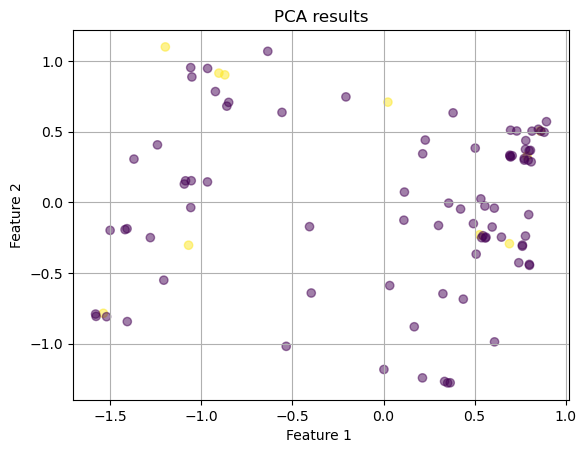

In [5]:
pca = PCA(n_components=10)  # 95% of variance
pca_result = pca.fit_transform(songs_num.drop(columns=['Song Popularity', 'Total Artists On Song']))
ranking_group = songs['Top 10 Song'].astype('category').cat.codes
plot_2D(pca_result, ranking_group, 'PCA')

I colored the points by whether they were a top 10 song or not. I'm not seeing any clustering with those particular songs, but I am seeing two bigger clusters separated by a diagonal line down the middle, which is interesting. I am not sure what these clusters are indicative of, however.

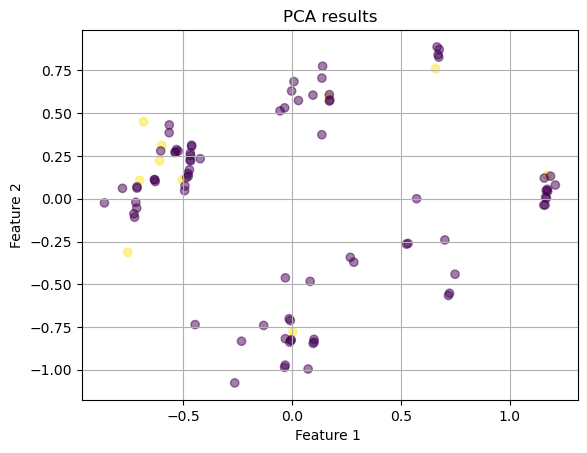

In [6]:
pca1 = PCA(n_components=10)  # 95% of variance
pca_result_1 = pca1.fit_transform(songs_num.drop(columns=['Song Popularity', 'Total Artists On Song', 'compound']))
plot_2D(pca_result_1, ranking_group, 'PCA')

Interestingly, when I remove the compound score from the sentiment analysis (leaving the positive, negative, neutral scores) I get much clearer clusters (still separated by the diagonal line) with all but 2 of the top songs in the top left cluster.

The following code has been adapted from lab 4.2. It takes in a pca model and plots the ratio of explained variance by each principal component. It then plots this.

Variance explained by each principal component:
[0.32070283 0.15954468 0.11482478 0.06969029 0.05864162 0.05514703
 0.04737073 0.03608452 0.0300553  0.02383462]


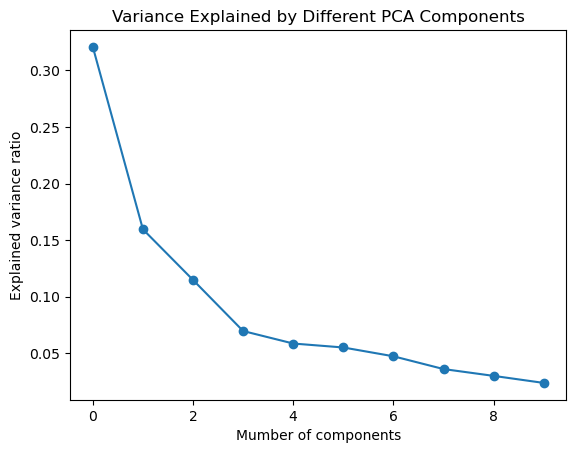

Variance explained by each principal component:
[0.24156774 0.17060014 0.10147743 0.08326044 0.07891062 0.06986966
 0.05186226 0.04267764 0.034445   0.03158158]


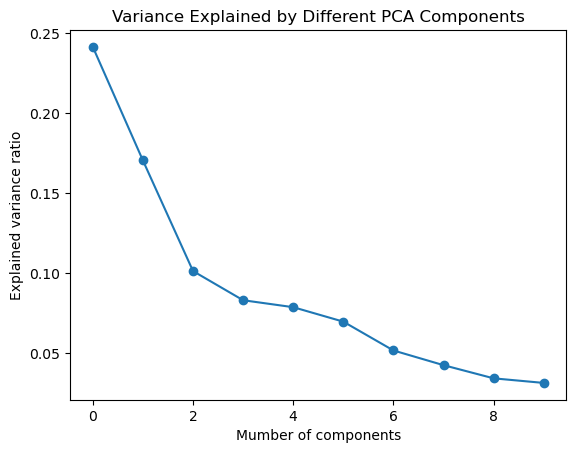

In [7]:
def plot_variance_explained(pca):
    print("Variance explained by each principal component:")
    print(pca.explained_variance_ratio_[0:10])

    plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, '-o')
    plt.xlabel('Mumber of components')
    plt.ylabel('Explained variance ratio')
    plt.title('Variance Explained by Different PCA Components')
    plt.show()

plot_variance_explained(pca)
plot_variance_explained(pca1)

These are two elbow plots showing the ratio of explained variance by each PCA. The first one is for the first model with the elbow point being at 2 components. After this, the explained variance decreases very slowly. For the second one, the elbow point is at either component 2 or 3. Therefore, 2 or 3 components would be optimal for a model.

#### T-SNE

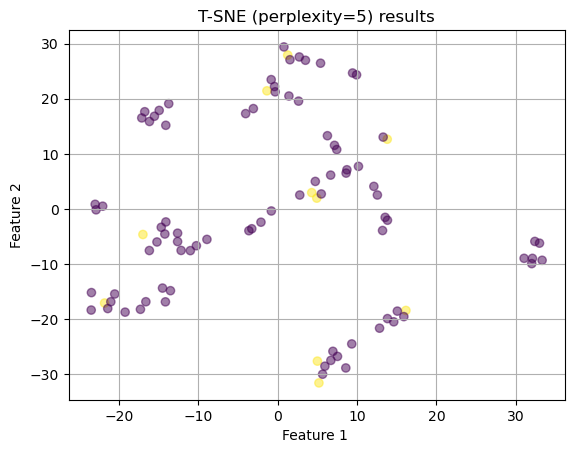

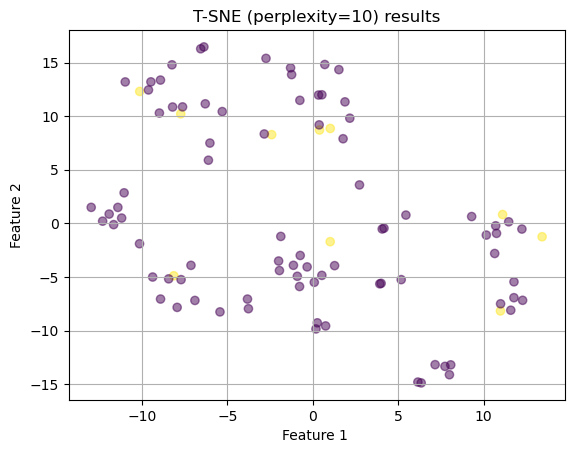

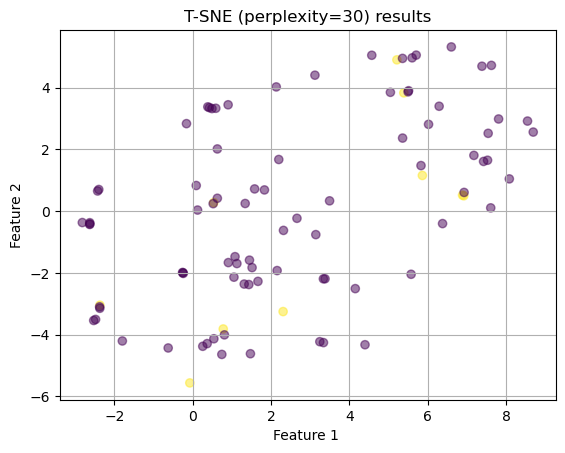

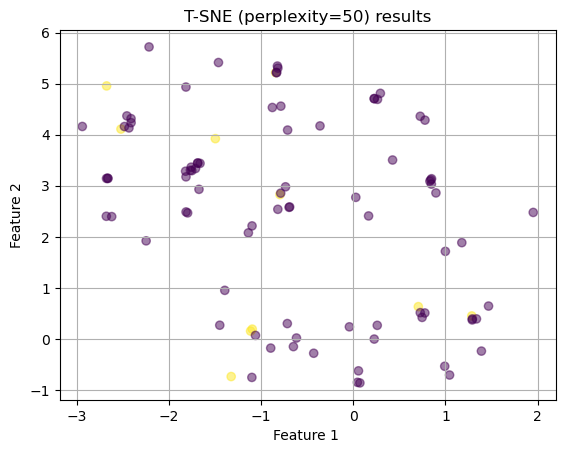

In [8]:
for perplexity in [5, 10, 30, 50]:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(songs_num.drop(columns=['Song Popularity', 'Total Artists On Song']))
    plot_2D(X_tsne, ranking_group, f'T-SNE (perplexity={perplexity})')

After running t-sne with several different perplexity values, I'm not seeing very many clear clusters. The best option is the first one with a perplexity of 5. I will try again taking out the compound score to see if that improves it.

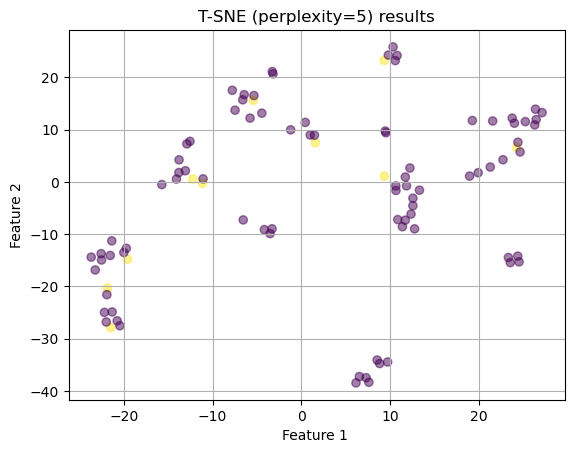

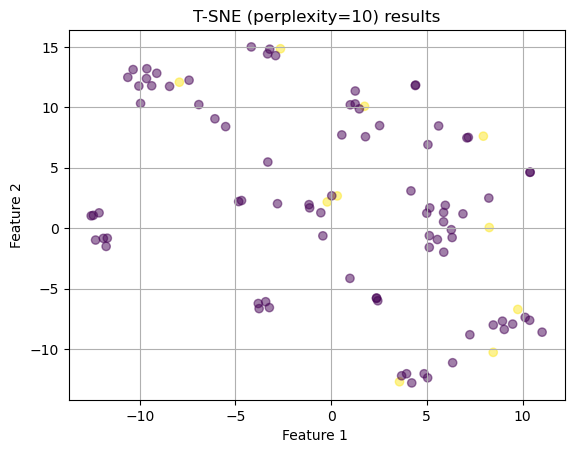

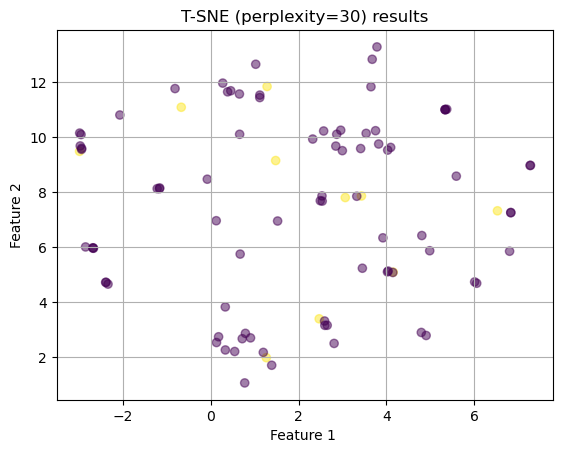

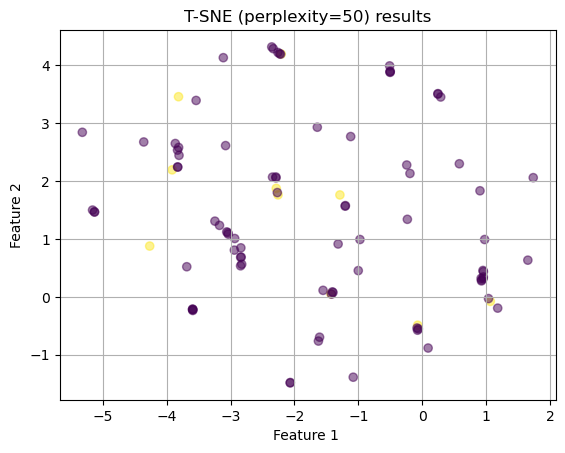

In [9]:
for perplexity in [5, 10, 30, 50]:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(songs_num.drop(columns=['Song Popularity', 'Total Artists On Song', 'compound']))
    plot_2D(X_tsne, ranking_group, f'T-SNE (perplexity={perplexity})')

The above graphs appear to have much clearer clusters. I think the best one is the first one with a perplexity of 5. I see distinct clusters. However, the top-10 songs did not appear to group together.

#### Comparison

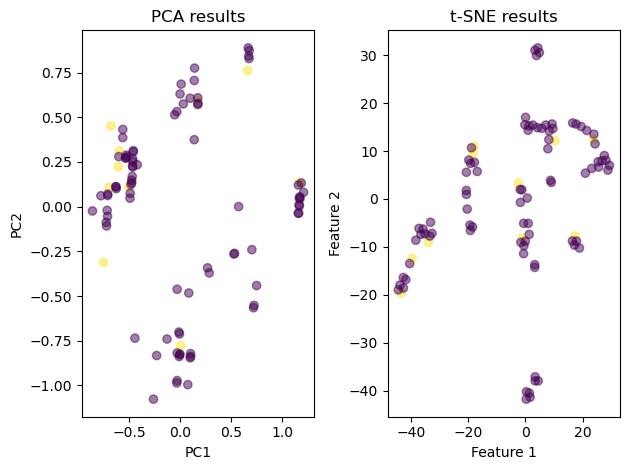

In [10]:
fig, axes = plt.subplots(1, 2)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(songs_num.drop(columns=['Song Popularity', 'Total Artists On Song', 'compound']))
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=ranking_group, alpha=0.5)
axes[0].set_title('PCA results')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# t-SNE
tsne = TSNE(n_components=2, perplexity=5)
X_tsne = tsne.fit_transform(songs_num.drop(columns=['Song Popularity', 'Total Artists On Song', 'compound']))
axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=ranking_group, alpha=0.5)
axes[1].set_title('t-SNE results')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()


I decided to put the two graphs together on the same subplot. This view of both methods shows that T-SNE did a much better job at visualizing clusters. The clusters are closer together and farther apart from each other. However, PCA did a better job of finding the top-10 songs grouped together (other than the 2 outliers) with T-SNE having 1-3 top 10 songs in each cluster.

In terms of preseriving the data structure, the fact that PCA kept the top-10 grouping as well as the characteristics of the method itself of projecting data in directions of max variance, I am led to believe that it does a good job of preserving the overall trends and variance but not as good of a job on a local level. This, instead, is where T-SNE does better. This might mean that T-SNE will do a better job showing groupings between songs (perhaps functioning as a recommendation system). Visually, T-SNE has more distinct clusters compared to PCA. However, the axes in PCA are more informative because they show the features produced with the greatest variance. Also, the PCA graph seems to have some underlying linearity which is intersting.

The tradeoffs between PCA and T-SNE include the interpretability (with PCA results being meaningful interpretations of the data and T-SNE features being more abstract), dimensionality (PCA can have any number of features while T-SNE is limited to 2-3), and visualization (T-SNE has clearer clusters while PCA's are more linear) - Source - ChatGPT.

#### K-Means

K Means clustering is a form of unsupervised learning that looks for the underlying patterns within the data without trying to predict pre determined labels. K Means creates K clusters that group together the points that are closest to the means of the clusters. The goal is that by finding the means of the clusters, data that is very similar to each other will all be grouped together and that there will be separations between the different groups. This is ultimately accomplished by minimizing the sum of squares within each cluster. Usually, we have to find the optimal number of K for the data.

The way that it works is by starting out with randomly assigned cluster centroids (means). It then puts each item in the group with it's closest mean. A new mean is found for the clusters and the points are all reassigned to their nearest centroid. This repeated a given number of times, with the clusters becoming more clear and closer together with each iteration. The method stops when either the centroids stop moving with each iteration or we have hit the maximum number of iterations. The means are calculated using Euclidean distance between all of the input features. The goal is to minimize the sum of squared distances between points and their centroids.

To find the optimal number of clusters, we can use the elbow method, where we graph the inertia vs the num clusters and then pick the elbow point, or where the rate of decrease of the inertia slows down significantly. This will give us the optimal number of clusters before we start losing information. Another option is the silhouette score. The score calculates how good of a match each point is with its cluster as opposed to other clusters. A score close to 1 means the point is close to other points in its own cluster and far away from other clusters. A score of 0 means the point is on the boundary between clusters. A score of -1 means a point is in the wrong cluster. The highest average silhouette score is chosen as the optimal number of clusters because it makes the best-defined clusters.

Source: [Geeks for Geeks](https://www.geeksforgeeks.org/k-means-clustering-introduction/)

The following code was adapted from lab 4.2. The methods were altered to only handle kmeans and produce final graphs for pca and t-sne based on the above results to visualize the clusters.

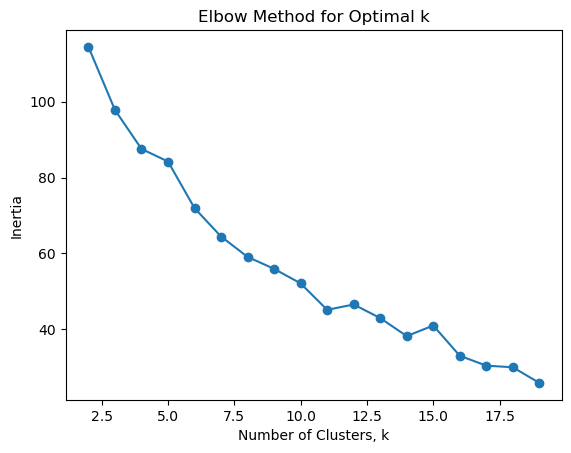

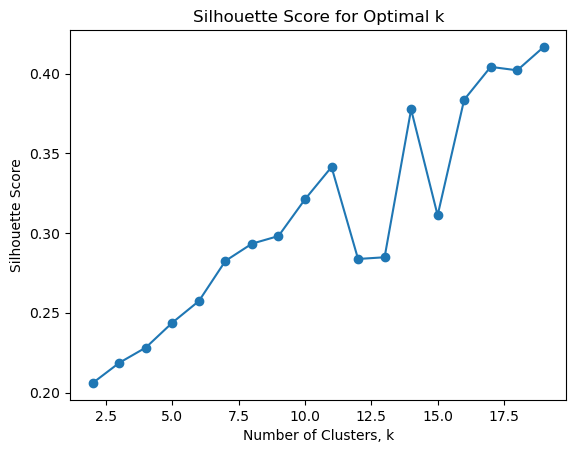

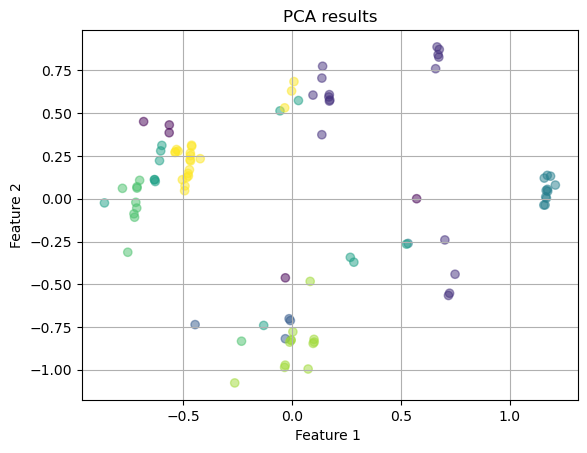

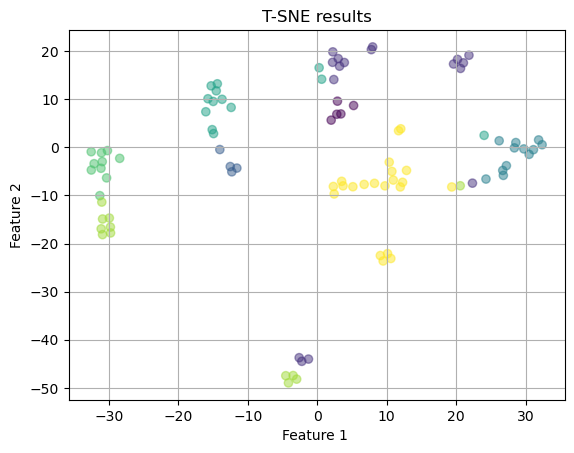

In [11]:
# source: James' lab demonstration
# function to create different models and fit model to data. Returns model inertia and labels
def kmean_fit(k, df):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(df)
    return kmeans.inertia_, kmeans.labels_

# empty lists to store info about different versions of models to graph
ks=[]
inertias=[]
silhouette_scores = []

# Test different numbers of clusters
for k in range(2,20):
    inertia, labels = kmean_fit(k, songs_num.drop(columns=['Song Popularity', 'Total Artists On Song', 'compound'])) # build and fit model
    ks.append(k) # keep track of number of clusters
    inertias.append(inertia)

    silhouette_avg = silhouette_score(songs_num.drop(columns=['Song Popularity', 'Total Artists On Song', 'compound']), labels) # calculate silhouette score
    silhouette_scores.append(silhouette_avg)

# graph num clusters vs inertia
plt.plot(ks,inertias,"-o")
plt.xlabel("Number of Clusters, k")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

# graph num clusters vs silhouette
plt.plot(ks, silhouette_scores, "-o")
plt.xlabel("Number of Clusters, k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.show()

# choose optimal nclusters of 2 (highest silhouette, inertia)
kmeans=KMeans(n_clusters=8)
kmeans.fit(songs_num.drop(columns=['Song Popularity', 'Total Artists On Song', 'compound']))
kmeans_labels = kmeans.predict(songs_num.drop(columns=['Song Popularity', 'Total Artists On Song', 'compound'])) # predict labels

pca = PCA(n_components=10)
X_pca = pca.fit_transform(songs_num.drop(columns=['Song Popularity', 'Total Artists On Song', 'compound']))
plot_2D(X_pca, kmeans_labels, 'PCA')

tsne = TSNE(n_components=2, perplexity=5)
X_tsne = tsne.fit_transform(songs_num.drop(columns=['Song Popularity', 'Total Artists On Song', 'compound']))
plot_2D(X_tsne, kmeans_labels, 'T-SNE')

Based on the silhouette score and elbow graph, I decided to choose 8 clusters as the optimal number of clusters. I think this was a good choice based on the T-SNE Results graph (the PCA graph is also pretty good, but probably could be better). The colors are separated for the most part and the clusters are far away from each other.

In [23]:
# Add the K-Means cluster labels back to the original DataFrame
songs['Cluster'] = kmeans_labels
# Group songs by their clusters and display
for cluster_num in sorted(songs['Cluster'].unique()):
    print(f"\nCluster {cluster_num}:")
    display(songs[songs['Cluster'] == cluster_num][['Track Name', 'Artists', 'Album', 'Genres', 'Top 10 Song', 'Cluster']])



Cluster 0:


,Track Name,Artists,Album,Genres,Top 10 Song,Cluster
6,Nasty,Tinashe,Nasty,"alternative r&b, dance pop, metropopolis, pop,...",1,0
45,TRYIN' MY HARDEST,SiR,HEAVY,"alternative r&b, la pop",0,0
60,Love Me JeJe,Tems,Born in the Wild,"afro r&b, afrobeats, alte, nigerian pop",0,0
65,DENIAL IS A RIVER,Doechii,Alligator Bites Never Heal,alternative r&b,0,0
69,Lagos Love Story,Ayra Starr,The Year I Turned 21,afrobeats,0,0



Cluster 1:


,Track Name,Artists,Album,Genres,Top 10 Song,Cluster
2,A Bar Song (Tipsy),Shaboozey,A Bar Song (Tipsy),"modern country pop, pop rap",1,1
3,Espresso,Sabrina Carpenter,Short n' Sweet,pop,1,1
10,YA YA,Beyoncé,COWBOY CARTER,"pop, r&b",0,1
15,Genesis.,RAYE,Genesis.,"uk contemporary r&b, uk pop",0,1
19,Gata Only,FloyyMenor,Gata Only,reggaeton chileno,0,1
24,HISS,Megan Thee Stallion,HISS,"houston rap, pop, rap, trap queen",0,1
26,I Had Some Help (Feat. Morgan Wallen),Post Malone,F-1 Trillion,"dfw rap, melodic rap, pop, rap",0,1
29,Modern Woman,Eliza McLamb,Going Through It,gen z singer-songwriter,0,1
30,Company Culture,Lambrini Girls,Company Culture,None Listed,0,1
37,obsessed,Olivia Rodrigo,GUTS (spilled),pop,0,1



Cluster 2:


,Track Name,Artists,Album,Genres,Top 10 Song,Cluster
46,BYE BYE,Kim Gordon,The Collective,"no wave, noise rock",0,2
62,The Lighthouse,Stevie Nicks,The Lighthouse,heartland rock,0,2
70,Wanting and Waiting,The Black Crowes,Happiness Bastards,"album rock, blues rock, classic rock, electric...",0,2
88,On The Game,The Black Keys,Ohio Players,"alternative rock, blues rock, garage rock, ind...",0,2



Cluster 3:


,Track Name,Artists,Album,Genres,Top 10 Song,Cluster
1,Not Like Us,Kendrick Lamar,Not Like Us,"conscious hip hop, hip hop, rap, west coast rap",1,3
11,Type Shit,Future,WE DON'T TRUST YOU,"atl hip hop, hip hop, rap, southern hip hop, trap",0,3
14,euphoria,Kendrick Lamar,euphoria,"conscious hip hop, hip hop, rap, west coast rap",0,3
27,Tough,Quavo,Tough,"atl hip hop, melodic rap, rap, trap",0,3
28,TGIF,GloRilla,GLORIOUS,southern hip hop,0,3
35,Never Lose Me (feat. SZA & Cardi B),Flo Milli,"Fine Ho, Stay",viral rap,0,3
49,Get It Sexyy,Sexyy Red,In Sexyy We Trust,trap queen,0,3
64,Fine Art,KNEECAP,Fine Art,irish hip hop,0,3
72,No One Else (feat. Jeremih),Lola Brooke,No One Else (feat. Jeremih),trap queen,0,3
84,KEHLANI (REMIX) [feat. Kehlani],Jordan Adetunji,KEHLANI (REMIX) [feat. Kehlani],irish hip hop,0,3



Cluster 4:


,Track Name,Artists,Album,Genres,Top 10 Song,Cluster
4,BIRDS OF A FEATHER,Billie Eilish,HIT ME HARD AND SOFT,"art pop, pop",1,4
8,"Girl, so confusing featuring lorde",Charli xcx,Brat and it’s completely different but also st...,"art pop, candy pop, metropopolis, pop, uk pop",1,4
16,Disease,Lady Gaga,Disease,"art pop, dance pop, pop",0,4
25,Von dutch,Charli xcx,BRAT,"art pop, candy pop, metropopolis, pop, uk pop",0,4
31,Always and Forever (feat. Hannah Diamond),SOPHIE,SOPHIE,"art pop, bubblegum bass, deconstructed club, e...",0,4
33,Fisherrr - Remix,Cash Cobain,Fisherrr (Remix),jersey club,0,4
42,Driver,Soccer Mommy,Evergreen,"art pop, bubblegrunge, indie pop, indie rock, ...",0,4
47,In The Wawa (Convinced I Am God),Lip Critic,Hex Dealer,digital hardcore,0,4
53,World on a String,Jessica Pratt,Here in the Pitch,"ambient folk, art pop, freak folk",0,4
55,Starburster,Fontaines D.C.,Romance,"crank wave, irish indie rock, irish post-punk",0,4



Cluster 5:


,Track Name,Artists,Album,Genres,Top 10 Song,Cluster
0,"Good Luck, Babe!",Chappell Roan,"Good Luck, Babe!",indie pop,1,5
9,Right Back to It,Waxahatchee,Tigers Blood,"alabama indie, bubblegrunge, chamber pop, coun...",1,5
13,Docket (feat. Bully),Blondshell,Docket (feat. Bully),"bubblegrunge, indie pop",0,5
17,Juna,Clairo,Charm,"bedroom pop, indie pop, pov: indie",0,5
52,Never Need Me,Rachel Chinouriri,What A Devastating Turn of Events,"indie pop, uk pop",0,5
63,Soup,Remi Wolf,Big Ideas,"indie pop, modern alternative pop",0,5
67,Beaches,beabadoobee,This Is How Tomorrow Moves,"bedroom pop, bubblegrunge, indie pop, pov: indie",0,5
76,Can't Be Still,illuminati hotties,POWER,bubblegrunge,0,5
79,California Highway 99,The Softies,The Bed I Made,"sacramento indie, tape club, twee pop",0,5
82,Milk,Abby Sage,The Rot,modern indie pop,0,5



Cluster 6:


,Track Name,Artists,Album,Genres,Top 10 Song,Cluster
7,Pink Skies,Zach Bryan,Pink Skies,classic oklahoma country,1,6
22,Angel Of My Dreams,JADE,Angel Of My Dreams,None Listed,0,6
23,She's Leaving You,MJ Lenderman,Manning Fireworks,"asheville indie, countrygaze, slacker rock",0,6
36,Darkest Hour (Helene Edit),Eric Church,Darkest Hour (Helene Edit),"contemporary country, country, country road",0,6
40,Si Antes Te Hubiera Conocido,KAROL G,Si Antes Te Hubiera Conocido,"reggaeton, reggaeton colombiano, urbano latino",0,6
48,Perfume,The Dare,What's Wrong With New York?,None Listed,0,6
51,Cardinal,Kacey Musgraves,Deeper Well,"classic texas country, contemporary country, c...",0,6
71,Carousel Horses,Christian Lee Hutson,Paradise Pop. 10,"countrygaze, deep new americana",0,6
74,Midas,Wunderhorse,Midas,None Listed,0,6
77,Radio Wave,Silverada,Silverada,"classic texas country, red dirt, roots americana",0,6



Cluster 7:


,Track Name,Artists,Album,Genres,Top 10 Song,Cluster
5,Too Sweet,Hozier,Unreal Unearth: Unaired,"irish singer-songwriter, modern rock, pop, pov...",1,7
12,we can't be friends (wait for your love),Ariana Grande,eternal sunshine,pop,0,7
18,Taste,Sabrina Carpenter,Short n' Sweet,pop,0,7
20,APT.,ROSÉ,APT.,k-pop,0,7
21,Diet Pepsi,Addison Rae,Diet Pepsi,social media pop,0,7
32,The Prophecy,Taylor Swift,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,pop,0,7
34,How Sweet,NewJeans,How Sweet,"k-pop, k-pop girl group",0,7
38,Igual Que Un Ángel (with Peso Pluma),Kali Uchis,ORQUÍDEAS,colombian pop,0,7
43,Anything,Griff,Vertigo,"alt z, uk pop",0,7
44,Saturn,SZA,Saturn,"pop, r&b, rap",0,7


I decided to display the playlists that would be made from these clusters. Looking at them, I can see that genre had a huge influence on the clusters, but there is also some variation that came from the other features. A manual overview of these playlists make me think that the algorithm did a good job. A lot of these artists (like Sabrina Carpenter, Taylor Swift, Ariana Grande, and Dua Lipa in cluster 7) are often listened to together. Overall, this method was strong. The top 10 songs were not clustered together, however. In regards to this as a known class, this method did not do a great job.

#### DBSCAN

DBSCAN is also a method for unsupervised learning where labels aren't provided to the model so it tries to figure out the underlying patterns in the data. DBSCAN stands for density-based spatial clustering of applications with noise. DBSCAN is special because it doesn't require clear shapes for the clusters and does not require optimization for the number of clusters. It also does a good job with noise. The main concept is the density of points, where we look for spaces that have a high density of points separated by spaces with a low density of points.

By separating points into core points (points with a min num of points in a specified range), border points (points within the specified range to the cores but don't achieve the min num points), and noise points (points that don't fit into either category and aren't really able to be included in a cluster), DBSCAN can make clusters that are arbitrary shapes and identify outliers. We can choose the max distance between points to be considered in the same cluster and the num points required to be considered a core point. The algorithm starts with a random point, finds all points that are close to it, counts how many there are, and labels the point a core or noise. If it is chosen as a core, then it creates a cluster and begins adding points to those clusters. It keeps adding core points until it hits a point classified as a border. Then, we go to another point that hasn't been classified yet. This is repeated until all points have been classified and analyzed. Finally, noise points are revisited to see if they are in a cluster. Anything left over is called noise.

We optimize the parameters (distance, min neighbors) using the silhouette score. We check for the max silhouette score by checking different possibilities for epsilon and min_samples and then calculating the average silhouette. The pair that gave us this max allows us to get the optimal parameters.

Source: [Data Camp](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm)

Code below is adapted from lab 4.2. I needed to add functionality for different numbers of clusters and pick what options to loop through to test different values for eps and min samples. I also added the new graphing functionality.

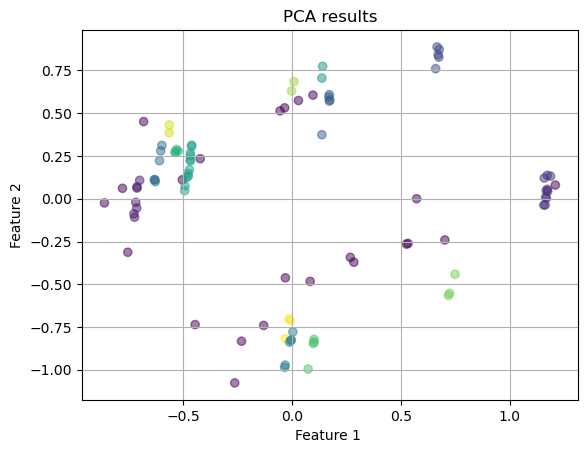

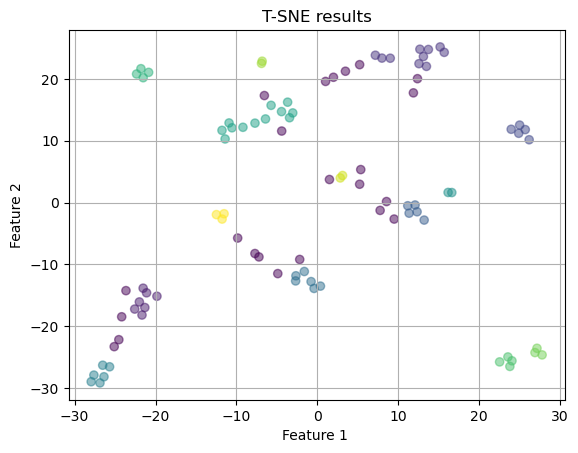

In [20]:
scores_analysis = songs_num.drop(columns=['Song Popularity', 'Total Artists On Song', 'compound'])
# holders to fill in with chosen scores
best_eps = None
best_min_samples = None
best_score = -1 # lowest possible score is -1 so look for a bigger score than that

# loop through different options of eps and min_samples
for eps in np.arange(0.1, 1.0, 0.1):
    for min_samples in range(2, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples) # build model
        cluster_labels = dbscan.fit_predict(scores_analysis) # get label
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)  # Exclude noise points (-1)
        if n_clusters < 2:
            continue
        
        score = silhouette_score(scores_analysis, cluster_labels) # calculate score
            
        if score > best_score: # if score improved
            best_eps = eps # save current eps
            best_min_samples = min_samples # save current min_samples
            best_score = score # save current best score

# create model with chosen optimal values
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(scores_analysis)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(scores_analysis)
plot_2D(X_pca, dbscan_labels, 'PCA')

tsne = TSNE(n_components=2, perplexity=5)
X_tsne = tsne.fit_transform(scores_analysis)
plot_2D(X_tsne, dbscan_labels, 'T-SNE')

The above are the results of DBSCAN clustering after optimizing the parameters. The T-SNE graph shows some very promising clusters. The purple cluster seems to be a bit concerning, but other clusters are separated from each other and do a good job collect nearby points are a bit more spread out. The clusters aren't quite so clear in this case.

In [22]:
songs['dbscan_Cluster'] = dbscan_labels
# Group songs by their clusters and display
for cluster_num in sorted(songs['dbscan_Cluster'].unique()):
    print(f"\nCluster {cluster_num}:")
    display(songs[songs['dbscan_Cluster'] == cluster_num][['Track Name', 'Artists', 'Album', 'Genres', 'Top 10 Song', 'dbscan_Cluster']])



Cluster -1:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
5,Too Sweet,Hozier,Unreal Unearth: Unaired,"irish singer-songwriter, modern rock, pop, pov...",1,-1
6,Nasty,Tinashe,Nasty,"alternative r&b, dance pop, metropopolis, pop,...",1,-1
9,Right Back to It,Waxahatchee,Tigers Blood,"alabama indie, bubblegrunge, chamber pop, coun...",1,-1
19,Gata Only,FloyyMenor,Gata Only,reggaeton chileno,0,-1
23,She's Leaving You,MJ Lenderman,Manning Fireworks,"asheville indie, countrygaze, slacker rock",0,-1
25,Von dutch,Charli xcx,BRAT,"art pop, candy pop, metropopolis, pop, uk pop",0,-1
27,Tough,Quavo,Tough,"atl hip hop, melodic rap, rap, trap",0,-1
33,Fisherrr - Remix,Cash Cobain,Fisherrr (Remix),jersey club,0,-1
40,Si Antes Te Hubiera Conocido,KAROL G,Si Antes Te Hubiera Conocido,"reggaeton, reggaeton colombiano, urbano latino",0,-1
42,Driver,Soccer Mommy,Evergreen,"art pop, bubblegrunge, indie pop, indie rock, ...",0,-1



Cluster 0:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
0,"Good Luck, Babe!",Chappell Roan,"Good Luck, Babe!",indie pop,1,0
13,Docket (feat. Bully),Blondshell,Docket (feat. Bully),"bubblegrunge, indie pop",0,0
17,Juna,Clairo,Charm,"bedroom pop, indie pop, pov: indie",0,0
52,Never Need Me,Rachel Chinouriri,What A Devastating Turn of Events,"indie pop, uk pop",0,0
67,Beaches,beabadoobee,This Is How Tomorrow Moves,"bedroom pop, bubblegrunge, indie pop, pov: indie",0,0
79,California Highway 99,The Softies,The Bed I Made,"sacramento indie, tape club, twee pop",0,0
82,Milk,Abby Sage,The Rot,modern indie pop,0,0



Cluster 1:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
1,Not Like Us,Kendrick Lamar,Not Like Us,"conscious hip hop, hip hop, rap, west coast rap",1,1
11,Type Shit,Future,WE DON'T TRUST YOU,"atl hip hop, hip hop, rap, southern hip hop, trap",0,1
14,euphoria,Kendrick Lamar,euphoria,"conscious hip hop, hip hop, rap, west coast rap",0,1
28,TGIF,GloRilla,GLORIOUS,southern hip hop,0,1
35,Never Lose Me (feat. SZA & Cardi B),Flo Milli,"Fine Ho, Stay",viral rap,0,1
49,Get It Sexyy,Sexyy Red,In Sexyy We Trust,trap queen,0,1
64,Fine Art,KNEECAP,Fine Art,irish hip hop,0,1
72,No One Else (feat. Jeremih),Lola Brooke,No One Else (feat. Jeremih),trap queen,0,1
84,KEHLANI (REMIX) [feat. Kehlani],Jordan Adetunji,KEHLANI (REMIX) [feat. Kehlani],irish hip hop,0,1
87,Big Dawgs,Hanumankind,Big Dawgs,"desi hip hop, indian underground rap, malayala...",0,1



Cluster 2:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
2,A Bar Song (Tipsy),Shaboozey,A Bar Song (Tipsy),"modern country pop, pop rap",1,2
24,HISS,Megan Thee Stallion,HISS,"houston rap, pop, rap, trap queen",0,2
26,I Had Some Help (Feat. Morgan Wallen),Post Malone,F-1 Trillion,"dfw rap, melodic rap, pop, rap",0,2
39,Enough (Miami),Cardi B,Enough (Miami),"pop, rap",0,2
61,Family Matters,Drake,Family Matters,"canadian hip hop, canadian pop, hip hop, pop r...",0,2



Cluster 3:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
3,Espresso,Sabrina Carpenter,Short n' Sweet,pop,1,3
29,Modern Woman,Eliza McLamb,Going Through It,gen z singer-songwriter,0,3
37,obsessed,Olivia Rodrigo,GUTS (spilled),pop,0,3
58,"I Love You, I'm Sorry",Gracie Abrams,The Secret of Us,alt z,0,3
68,JOYRIDE,Kesha,JOYRIDE,"dance pop, pop",0,3



Cluster 4:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
4,BIRDS OF A FEATHER,Billie Eilish,HIT ME HARD AND SOFT,"art pop, pop",1,4
8,"Girl, so confusing featuring lorde",Charli xcx,Brat and it’s completely different but also st...,"art pop, candy pop, metropopolis, pop, uk pop",1,4
16,Disease,Lady Gaga,Disease,"art pop, dance pop, pop",0,4
31,Always and Forever (feat. Hannah Diamond),SOPHIE,SOPHIE,"art pop, bubblegum bass, deconstructed club, e...",0,4
53,World on a String,Jessica Pratt,Here in the Pitch,"ambient folk, art pop, freak folk",0,4
91,Britpop,A. G. Cook,Britpop,"bubblegum bass, escape room, hyperpop, proto-h...",0,4



Cluster 5:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
7,Pink Skies,Zach Bryan,Pink Skies,classic oklahoma country,1,5
36,Darkest Hour (Helene Edit),Eric Church,Darkest Hour (Helene Edit),"contemporary country, country, country road",0,5
51,Cardinal,Kacey Musgraves,Deeper Well,"classic texas country, contemporary country, c...",0,5
71,Carousel Horses,Christian Lee Hutson,Paradise Pop. 10,"countrygaze, deep new americana",0,5
77,Radio Wave,Silverada,Silverada,"classic texas country, red dirt, roots americana",0,5
83,Dammit Randy,Miranda Lambert,Dammit Randy,"contemporary country, country, country dawn, c...",0,5



Cluster 6:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
10,YA YA,Beyoncé,COWBOY CARTER,"pop, r&b",0,6
15,Genesis.,RAYE,Genesis.,"uk contemporary r&b, uk pop",0,6



Cluster 7:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
12,we can't be friends (wait for your love),Ariana Grande,eternal sunshine,pop,0,7
18,Taste,Sabrina Carpenter,Short n' Sweet,pop,0,7
21,Diet Pepsi,Addison Rae,Diet Pepsi,social media pop,0,7
32,The Prophecy,Taylor Swift,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,pop,0,7
38,Igual Que Un Ángel (with Peso Pluma),Kali Uchis,ORQUÍDEAS,colombian pop,0,7
43,Anything,Griff,Vertigo,"alt z, uk pop",0,7
59,215634,Elvie Shane,Damascus,modern country pop,0,7
73,Training Season,Dua Lipa,Radical Optimism,"dance pop, pop, uk pop",0,7
80,Use Me,Zach Top,Cold Beer & Country Music,modern country pop,0,7
85,That's My Floor,Magdalena Bay,Imaginal Disk,la pop,0,7



Cluster 8:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
20,APT.,ROSÉ,APT.,k-pop,0,8
34,How Sweet,NewJeans,How Sweet,"k-pop, k-pop girl group",0,8
66,New Woman (feat. ROSALÍA),LISA,New Woman (feat. ROSALÍA),k-pop,0,8
90,XO (Only If You Say Yes),ENHYPEN,ROMANCE : UNTOLD,"anime, k-pop boy group",0,8



Cluster 9:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
22,Angel Of My Dreams,JADE,Angel Of My Dreams,None Listed,0,9
48,Perfume,The Dare,What's Wrong With New York?,None Listed,0,9
74,Midas,Wunderhorse,Midas,None Listed,0,9
81,Masquerade,Original Cast of Stereophonic,Stereophonic (Original Cast Recording),None Listed,0,9



Cluster 10:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
30,Company Culture,Lambrini Girls,Company Culture,None Listed,0,10
41,Bon Bon,Fcukers,Bon Bon,None Listed,0,10
56,Get In With Me,BossMan Dlow,Mr Beat The Road,None Listed,0,10



Cluster 11:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
44,Saturn,SZA,Saturn,"pop, r&b, rap",0,11
89,After Hours,Kehlani,CRASH,"pop, r&b, rap",0,11



Cluster 12:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
45,TRYIN' MY HARDEST,SiR,HEAVY,"alternative r&b, la pop",0,12
60,Love Me JeJe,Tems,Born in the Wild,"afro r&b, afrobeats, alte, nigerian pop",0,12



Cluster 13:


,Track Name,Artists,Album,Genres,Top 10 Song,dbscan_Cluster
46,BYE BYE,Kim Gordon,The Collective,"no wave, noise rock",0,13
62,The Lighthouse,Stevie Nicks,The Lighthouse,heartland rock,0,13
70,Wanting and Waiting,The Black Crowes,Happiness Bastards,"album rock, blues rock, classic rock, electric...",0,13


Again, after looking at the playlists, I can see how genre has the biggest influence on these clusters. These actually seem to be a bit more accurate with the playlists. However, none of the top-10 songs were clustered together. That means that this was not optimal in identifying hit songs.

### Clustering Methods
Apply clustering techniques (K-Means, DBSCAN, and Hierarchical clustering) to a selected dataset. The goal is to understand how each method works, compare their performance, and interpret the results.

1. Clustering Methods:
    - Apply K-Means, DBSCAN, and Hierarchical clustering to your dataset.
    - Write a technical summary for each method (2–4 paragraphs per method) explaining how it works, its purpose, and any model selection methods used (e.g., Elbow, Silhouette).

2. Results Section:
    - Discuss and visualize the results of each clustering analysis.
    - Compare the performance of different clustering methods, noting any insights gained from the analysis.
    - Visualize cluster patterns and how they relate (if at all) to existing labels in the dataset.
    - Use professional, labeled, and clear visualizations that support your discussion.

3. Conclusion:
    - Summarize the key findings and their real-world implications in a non-technical way. Focus on the most important results and how they could apply to practical situations.

#### Hierarchical (Agglomerative) Clustering

Hierarchical clustering is a way to build a hierarchy of clusters when we don't know how many clusters we should make. The goal is to get nested groupings of data points that progressively increase the number of points assigned to the clusters. I am planning on using agglomerative clustering which is also known as a "bottom-up" approach. The final clusters can be visualized  in a tree called a dendogram that shows how the different levels of clusters changes.

Agglomerative clustering starts by assuming every data point is its own cluster and then progressively adding more points. The method first finds the distance between each pair of points using Euclidean distance. It then finds the two closest clusters and merges them into a new cluster. It then finds the new distance between this cluster and the other clusters. This goes on until all of the data points are put into one cluster or there is some other stopping criteria (max iterations, num clusters).

We can find the optimal number of clusters using the silhouette scores. By finding the number of clusters that provided the maximum average silhouette score, we find the optimal that should be used.

Source: [Geeks for Geeks](https://www.geeksforgeeks.org/hierarchical-clustering-with-scikit-learn/)

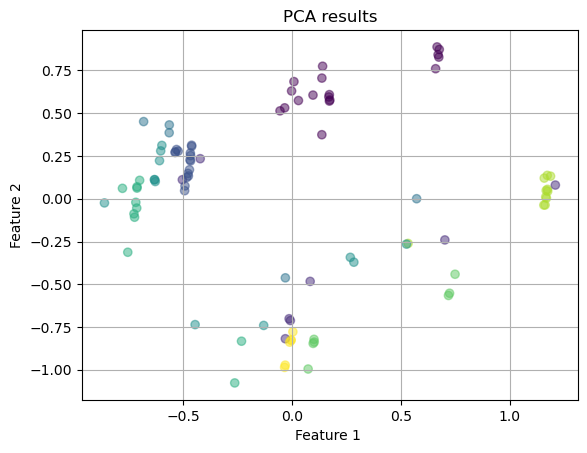

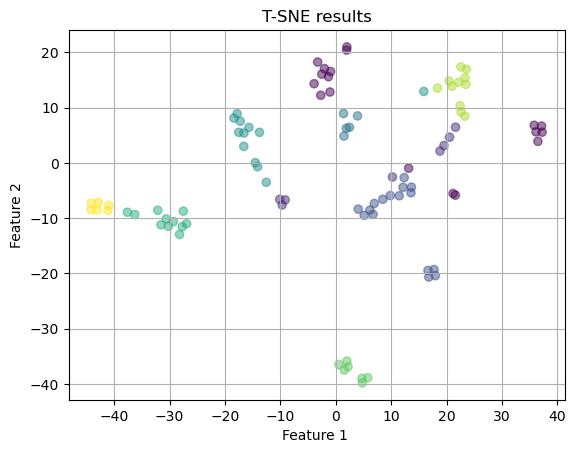

In [25]:
scores_analysis = songs_num.drop(columns=['Song Popularity', 'Total Artists On Song', 'compound'])
# holders to fill in with chosen scores
best_cs =None
best_score = -1 # lowest possible score is -1 so look for a bigger score than that

# loop through different options of n_clusters
for n_cs in range(2, 10):
    agg_clust = AgglomerativeClustering(n_clusters=n_cs) # build model
    cluster_labels = agg_clust.fit_predict(scores_analysis) # get label
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)  # Exclude noise points (-1)
    if n_clusters < 2:
        continue
    
    score = silhouette_score(scores_analysis, cluster_labels) # calculate score
        
    if score > best_score: # if score improved
        best_cs = n_cs
        best_score = score # save current best score

# create model with chosen optimal values
agg_clust = AgglomerativeClustering(n_clusters=best_cs)
agg_labels = agg_clust.fit_predict(scores_analysis)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(scores_analysis)
plot_2D(X_pca, agg_labels, 'PCA')

tsne = TSNE(n_components=2, perplexity=5)
X_tsne = tsne.fit_transform(scores_analysis)
plot_2D(X_tsne, agg_labels, 'T-SNE')

These clusters are extremely clear in the T-SNE graph. They are all distinct and separated from each other. The PCA graph also has good clusters on the left side, but the right side is not as clear. Overall, I think this is the best method for clustering.

In [26]:
songs['agg_Cluster'] = agg_labels
# Group songs by their clusters and display
for cluster_num in sorted(songs['agg_Cluster'].unique()):
    print(f"\nCluster {cluster_num}:")
    display(songs[songs['agg_Cluster'] == cluster_num][['Track Name', 'Artists', 'Album', 'Genres', 'Top 10 Song', 'agg_Cluster']])



Cluster 0:


,Track Name,Artists,Album,Genres,Top 10 Song,agg_Cluster
2,A Bar Song (Tipsy),Shaboozey,A Bar Song (Tipsy),"modern country pop, pop rap",1,0
3,Espresso,Sabrina Carpenter,Short n' Sweet,pop,1,0
10,YA YA,Beyoncé,COWBOY CARTER,"pop, r&b",0,0
15,Genesis.,RAYE,Genesis.,"uk contemporary r&b, uk pop",0,0
24,HISS,Megan Thee Stallion,HISS,"houston rap, pop, rap, trap queen",0,0
25,Von dutch,Charli xcx,BRAT,"art pop, candy pop, metropopolis, pop, uk pop",0,0
26,I Had Some Help (Feat. Morgan Wallen),Post Malone,F-1 Trillion,"dfw rap, melodic rap, pop, rap",0,0
29,Modern Woman,Eliza McLamb,Going Through It,gen z singer-songwriter,0,0
37,obsessed,Olivia Rodrigo,GUTS (spilled),pop,0,0
39,Enough (Miami),Cardi B,Enough (Miami),"pop, rap",0,0



Cluster 1:


,Track Name,Artists,Album,Genres,Top 10 Song,agg_Cluster
5,Too Sweet,Hozier,Unreal Unearth: Unaired,"irish singer-songwriter, modern rock, pop, pov...",1,1
19,Gata Only,FloyyMenor,Gata Only,reggaeton chileno,0,1
40,Si Antes Te Hubiera Conocido,KAROL G,Si Antes Te Hubiera Conocido,"reggaeton, reggaeton colombiano, urbano latino",0,1
46,BYE BYE,Kim Gordon,The Collective,"no wave, noise rock",0,1
54,Cómo Dónde y Cuándo,Shakira,Las Mujeres Ya No Lloran,"colombian pop, dance pop, latin pop, pop",0,1
62,The Lighthouse,Stevie Nicks,The Lighthouse,heartland rock,0,1
70,Wanting and Waiting,The Black Crowes,Happiness Bastards,"album rock, blues rock, classic rock, electric...",0,1
92,ADIVINO,Myke Towers,ADIVINO,"reggaeton, trap latino, urbano latino",0,1



Cluster 2:


,Track Name,Artists,Album,Genres,Top 10 Song,agg_Cluster
12,we can't be friends (wait for your love),Ariana Grande,eternal sunshine,pop,0,2
18,Taste,Sabrina Carpenter,Short n' Sweet,pop,0,2
20,APT.,ROSÉ,APT.,k-pop,0,2
21,Diet Pepsi,Addison Rae,Diet Pepsi,social media pop,0,2
32,The Prophecy,Taylor Swift,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,pop,0,2
34,How Sweet,NewJeans,How Sweet,"k-pop, k-pop girl group",0,2
38,Igual Que Un Ángel (with Peso Pluma),Kali Uchis,ORQUÍDEAS,colombian pop,0,2
43,Anything,Griff,Vertigo,"alt z, uk pop",0,2
59,215634,Elvie Shane,Damascus,modern country pop,0,2
66,New Woman (feat. ROSALÍA),LISA,New Woman (feat. ROSALÍA),k-pop,0,2



Cluster 3:


,Track Name,Artists,Album,Genres,Top 10 Song,agg_Cluster
6,Nasty,Tinashe,Nasty,"alternative r&b, dance pop, metropopolis, pop,...",1,3
45,TRYIN' MY HARDEST,SiR,HEAVY,"alternative r&b, la pop",0,3
60,Love Me JeJe,Tems,Born in the Wild,"afro r&b, afrobeats, alte, nigerian pop",0,3
65,DENIAL IS A RIVER,Doechii,Alligator Bites Never Heal,alternative r&b,0,3
69,Lagos Love Story,Ayra Starr,The Year I Turned 21,afrobeats,0,3



Cluster 4:


,Track Name,Artists,Album,Genres,Top 10 Song,agg_Cluster
4,BIRDS OF A FEATHER,Billie Eilish,HIT ME HARD AND SOFT,"art pop, pop",1,4
8,"Girl, so confusing featuring lorde",Charli xcx,Brat and it’s completely different but also st...,"art pop, candy pop, metropopolis, pop, uk pop",1,4
16,Disease,Lady Gaga,Disease,"art pop, dance pop, pop",0,4
31,Always and Forever (feat. Hannah Diamond),SOPHIE,SOPHIE,"art pop, bubblegum bass, deconstructed club, e...",0,4
33,Fisherrr - Remix,Cash Cobain,Fisherrr (Remix),jersey club,0,4
42,Driver,Soccer Mommy,Evergreen,"art pop, bubblegrunge, indie pop, indie rock, ...",0,4
47,In The Wawa (Convinced I Am God),Lip Critic,Hex Dealer,digital hardcore,0,4
53,World on a String,Jessica Pratt,Here in the Pitch,"ambient folk, art pop, freak folk",0,4
55,Starburster,Fontaines D.C.,Romance,"crank wave, irish indie rock, irish post-punk",0,4
78,Ajhussi,Flying Lotus,Spirit Box,"afrofuturism, alternative hip hop, electronica...",0,4



Cluster 5:


,Track Name,Artists,Album,Genres,Top 10 Song,agg_Cluster
0,"Good Luck, Babe!",Chappell Roan,"Good Luck, Babe!",indie pop,1,5
9,Right Back to It,Waxahatchee,Tigers Blood,"alabama indie, bubblegrunge, chamber pop, coun...",1,5
13,Docket (feat. Bully),Blondshell,Docket (feat. Bully),"bubblegrunge, indie pop",0,5
17,Juna,Clairo,Charm,"bedroom pop, indie pop, pov: indie",0,5
23,She's Leaving You,MJ Lenderman,Manning Fireworks,"asheville indie, countrygaze, slacker rock",0,5
52,Never Need Me,Rachel Chinouriri,What A Devastating Turn of Events,"indie pop, uk pop",0,5
63,Soup,Remi Wolf,Big Ideas,"indie pop, modern alternative pop",0,5
67,Beaches,beabadoobee,This Is How Tomorrow Moves,"bedroom pop, bubblegrunge, indie pop, pov: indie",0,5
76,Can't Be Still,illuminati hotties,POWER,bubblegrunge,0,5
79,California Highway 99,The Softies,The Bed I Made,"sacramento indie, tape club, twee pop",0,5



Cluster 6:


,Track Name,Artists,Album,Genres,Top 10 Song,agg_Cluster
22,Angel Of My Dreams,JADE,Angel Of My Dreams,None Listed,0,6
30,Company Culture,Lambrini Girls,Company Culture,None Listed,0,6
41,Bon Bon,Fcukers,Bon Bon,None Listed,0,6
48,Perfume,The Dare,What's Wrong With New York?,None Listed,0,6
56,Get In With Me,BossMan Dlow,Mr Beat The Road,None Listed,0,6
74,Midas,Wunderhorse,Midas,None Listed,0,6
81,Masquerade,Original Cast of Stereophonic,Stereophonic (Original Cast Recording),None Listed,0,6



Cluster 7:


,Track Name,Artists,Album,Genres,Top 10 Song,agg_Cluster
1,Not Like Us,Kendrick Lamar,Not Like Us,"conscious hip hop, hip hop, rap, west coast rap",1,7
11,Type Shit,Future,WE DON'T TRUST YOU,"atl hip hop, hip hop, rap, southern hip hop, trap",0,7
14,euphoria,Kendrick Lamar,euphoria,"conscious hip hop, hip hop, rap, west coast rap",0,7
27,Tough,Quavo,Tough,"atl hip hop, melodic rap, rap, trap",0,7
28,TGIF,GloRilla,GLORIOUS,southern hip hop,0,7
35,Never Lose Me (feat. SZA & Cardi B),Flo Milli,"Fine Ho, Stay",viral rap,0,7
49,Get It Sexyy,Sexyy Red,In Sexyy We Trust,trap queen,0,7
64,Fine Art,KNEECAP,Fine Art,irish hip hop,0,7
72,No One Else (feat. Jeremih),Lola Brooke,No One Else (feat. Jeremih),trap queen,0,7
84,KEHLANI (REMIX) [feat. Kehlani],Jordan Adetunji,KEHLANI (REMIX) [feat. Kehlani],irish hip hop,0,7



Cluster 8:


,Track Name,Artists,Album,Genres,Top 10 Song,agg_Cluster
7,Pink Skies,Zach Bryan,Pink Skies,classic oklahoma country,1,8
36,Darkest Hour (Helene Edit),Eric Church,Darkest Hour (Helene Edit),"contemporary country, country, country road",0,8
51,Cardinal,Kacey Musgraves,Deeper Well,"classic texas country, contemporary country, c...",0,8
71,Carousel Horses,Christian Lee Hutson,Paradise Pop. 10,"countrygaze, deep new americana",0,8
77,Radio Wave,Silverada,Silverada,"classic texas country, red dirt, roots americana",0,8
83,Dammit Randy,Miranda Lambert,Dammit Randy,"contemporary country, country, country dawn, c...",0,8


Again, this clustering method put a lot of weight on the genre of the songs. The top 10 songs are not clustered together. I think these playlists are also very strong and represent good groupings of songs.

## Summary and Interpretation of Results
Summarize your findings, interpret the results, and discuss their technical implications.
